# Goodreads Data Wrangling


### Introduction

This notebook uses data from the Goodreads Books dataset found here:
https://www.kaggle.com/jealousleopard/goodreadsbooks. This dataset is interesting to me because I've been using goodreads to keep track of my books, keep up to date with what my friends have been reading, and discover new books for years.

### Import Packages

In [141]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

### Import Datum

In [142]:
import warnings
warnings.simplefilter("ignore")
books = pd.read_csv('https://raw.githubusercontent.com/RobinLuke/Goodreads-Data-Wrangling/master/books.csv', error_bad_lines = False)

b'Skipping line 3350: expected 12 fields, saw 13\nSkipping line 4704: expected 12 fields, saw 13\nSkipping line 5879: expected 12 fields, saw 13\nSkipping line 8981: expected 12 fields, saw 13\n'


### Let's get a good overview of the data

In [143]:
books[:3]

,bookID,title,authors,average_rating,isbn,isbn13,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,0439785960,9780439785969,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,0439358078,9780439358071,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,0439554896,9780439554893,eng,352,6333,244,11/1/2003,Scholastic


### It looks like there are isbn columns that we don't care about, let's drop those to clean the data up.

In [144]:
books = books.drop(columns = ['isbn', 'isbn13'])

### Let's take a look at the languages present.
#### The languages may be interesting because they provide a good overview of where the most books are published and provide a sort of popularity list.

In [145]:
books.language_code.unique()

array(['eng', 'en-US', 'fre', 'spa', 'en-GB', 'mul', 'grc', 'enm',
       'en-CA', 'ger', 'jpn', 'ara', 'nl', 'zho', 'lat', 'por', 'srp',
       'ita', 'rus', 'msa', 'glg', 'wel', 'swe', 'nor', 'tur', 'gla',
       'ale'], dtype=object)

#### It looks like there are multiple versions of english listed here, let's combine all of them into the 'eng' category for simplicity.

In [146]:
books.replace(to_replace=['en-US', 'en-GB', 'en-CA'], value = 'eng', inplace=True)
print(books.language_code.unique())
books[:3]

['eng' 'fre' 'spa' 'mul' 'grc' 'enm' 'ger' 'jpn' 'ara' 'nl' 'zho' 'lat'
 'por' 'srp' 'ita' 'rus' 'msa' 'glg' 'wel' 'swe' 'nor' 'tur' 'gla' 'ale']


,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,9/16/2006,Scholastic Inc.
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,9/1/2004,Scholastic Inc.
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,11/1/2003,Scholastic


### Let's take a look at the most popular languages on GoodReads.
#### It's almost certain that english will be far ahead of the other languages due to the nature of the site, but I'm interested to find out how far ahead it is compared to other languages.

In [147]:
popLang = books.groupby('language_code')['title'].count().sort_values(ascending = False)
print(popLang[:5])

language_code
eng    10537
spa      218
fre      144
ger       99
jpn       46
Name: title, dtype: int64


#### It looks like English is ahead of the others by a long shot, but by how much?
#### Let's visualize it.

Text(0.5, 1.0, 'Proportion of book languages present')

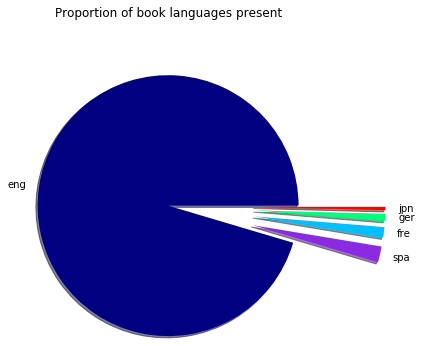

In [148]:
plt.pie(popLang[:5], labels = popLang[:5].index.tolist(), 
        explode = [0,1,1,1,1], shadow = True, radius = 1.5,
        colors = ['navy', 'blueviolet', 'deepskyblue', 'springgreen', 'red'])
plt.title("Proportion of book languages present", pad = 80)

#### Now let's see if there is a correlation between language and average rating.

Text(0, 0.5, 'Average Rating')

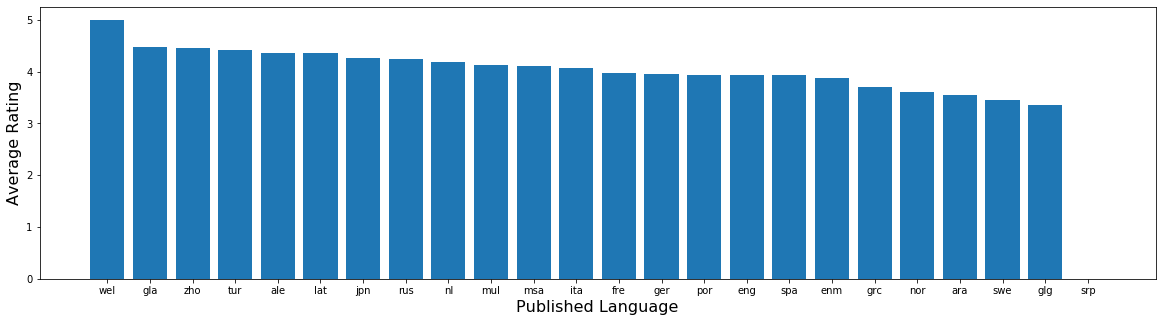

In [149]:
lang = books.groupby('language_code')['average_rating'].mean().sort_values(ascending = False)
fig, ax = plt.subplots(figsize = (20,5))
ax.bar(x = lang.index.tolist(), height = lang)
ax.set_xlabel("Published Language", fontsize = 16)
ax.set_ylabel("Average Rating", fontsize = 16)

#### It seems like the less popular languages are rated more highly on average than the more popular languages (namely english). We'll try and make sense of this in the conclusion.

### Let's take a look at the publishers.
#### I'm interested to find out if the large publishers dominate the market as much as they seem to dominate the bookstores. Working in the bookstore at the student center has made me much more aware of what company publishes books and textbooks.

In [150]:
books.publisher.unique()

array(['Scholastic Inc.', 'Scholastic', 'Nimble Books', ..., 'Suma',
       'Panamericana Editorial', 'Editorial Presença'], dtype=object)

#### Hm, looks like there are a lot of them. I'll clean up some of the more popular ones so that they're easier to work with.

#### Find out what the most popular publishers are.

In [151]:
books.groupby('publisher')['title'].count().sort_values(ascending = False)

publisher
Vintage                   318
Penguin Books             261
Penguin Classics          184
Mariner Books             150
Ballantine Books          144
                         ... 
Harvest Books/Harcourt      1
Redleaf Press               1
Red Hen Pr                  1
Haus Publishing             1
Limitless Corporation       1
Name: title, Length: 2290, dtype: int64

#### It looks like there are some duplicates, let's take some of the duplicates out from some publishers I see on the list and know from experience.

In [152]:
print(books.loc[books['publisher'].str.contains('Vintage')]['publisher'].unique()[:4], '\n')
print(books.loc[books['publisher'].str.contains('Scholastic')]['publisher'].unique()[:4], '\n')
print(books.loc[books['publisher'].str.contains('Penguin')]['publisher'].unique()[:4])

['Vintage' 'Vintage Crime/Black Lizard' 'Vintage Contemporaries'
 'Vintage International'] 

['Scholastic Inc.' 'Scholastic' 'Scholastic Paperbacks' 'Scholastic Books'] 

['Penguin Classics' 'Penguin Books' 'Penguin' 'Penguin Press']


In [153]:
books.replace(to_replace=books.loc[books['publisher'].str.contains('Vintage')]['publisher'].unique(), value = 'Vintage', inplace=True)
print(books.loc[books['publisher'].str.contains('Vintage')]['publisher'].unique())

books.replace(to_replace=books.loc[books['publisher'].str.contains('Scholastic')]['publisher'].unique(), value = 'Scholastic', inplace=True)
print(books.loc[books['publisher'].str.contains('Scholastic')]['publisher'].unique())

books.replace(to_replace=books.loc[books['publisher'].str.contains('Penguin')]['publisher'].unique(), value = 'Penguin', inplace=True)
print(books.loc[books['publisher'].str.contains('Penguin')]['publisher'].unique())

['Vintage']
['Scholastic']
['Penguin']


#### Let's plot that the popular publishers to make it easier to read.

Text(0, 0.5, 'Number of Titles Published')

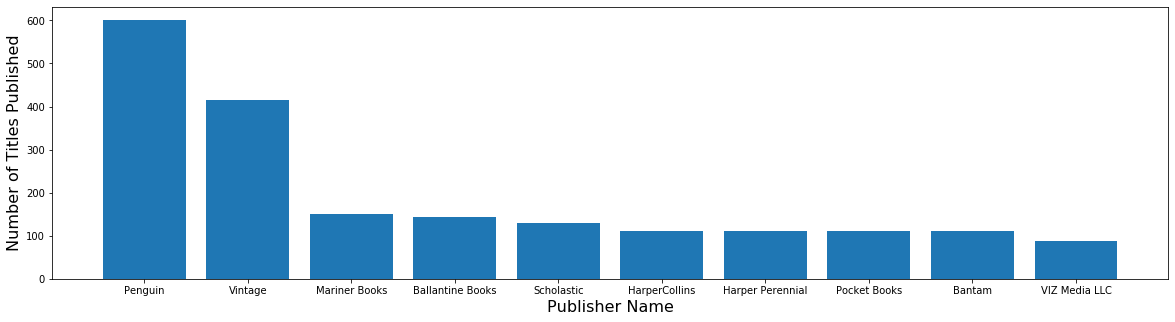

In [154]:
popPubs = books.groupby('publisher')['title'].count().sort_values(ascending = False)
fig, ax = plt.subplots(figsize = (20,5))
ax.bar(x = popPubs.index.tolist()[:10], height = popPubs[:10])
ax.set_xlabel("Publisher Name", fontsize = 16)
ax.set_ylabel("Number of Titles Published", fontsize = 16)

#### It looks like the major publishers really do control a large amount of the books that are rated on goodreads, but does this mean that the titles they publish are better than those of the less popular publishers?

Text(0, 0.5, 'Average Rating of Titles Published')

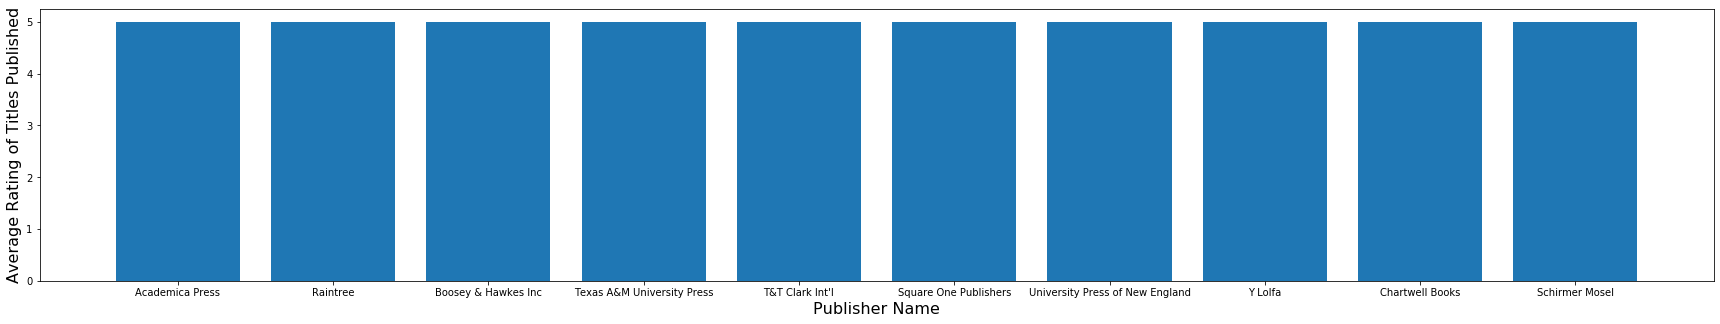

In [155]:
pubs = books.groupby('publisher')['average_rating'].mean().sort_values(ascending = False)
fig, ax = plt.subplots(figsize = (30,5))
ax.bar(x = pubs.index.tolist()[:10], height = pubs[:10])
ax.set_xlabel("Publisher Name", fontsize = 16)
ax.set_ylabel("Average Rating of Titles Published", fontsize = 16)

#### It appears as if the larger companies are not the front runners for having a higher average book rating.

### Now let's look at ratings & reviews.
#### I like many others have a favorite book series that gets _way_ too little attention, especially online. I'm curious to see how my favorite books and authors fair in the runnings.

#### First, a look at the highest rated books.

In [156]:
books.groupby('title')['average_rating'].mean().reset_index().sort_values('average_rating', ascending = False)[:5]

,title,average_rating
7190,The Complete Theory Fun Factory: Music Theory ...,5.0
7892,The Irish Anatomist: A Study of Flann O'Brien,5.0
1554,Colossians and Philemon: A Critical and Exeget...,5.0
6645,The American Campaign: U.S. Presidential Campa...,5.0
965,Bill Gates: Computer Legend (Famous Lives),5.0


#### It looks like a lot of these are lesser-known books likely with only a few reviews. Let's filter out books that have less than 100 reviews so that we get a better sample of the professionally published population.

In [157]:
print(books.count()[0] - books[books['ratings_count'] > 100].count()[0], "\nThat's a lot of books that we removed...")
books = books[books['ratings_count'] > 100]
books.groupby('title')['average_rating'].mean().reset_index().sort_values('average_rating', ascending = False)[:5]

2730 
That's a lot of books that we removed...


,title,average_rating
5355,The Complete Calvin and Hobbes,4.82
2242,Harry Potter Boxed Set Books 1-5 (Harry Potte...,4.78
2668,It's a Magical World (Calvin and Hobbes #11),4.76
2243,Harry Potter Collection (Harry Potter #1-6),4.73
1561,Early Color,4.73


#### I see that Calvin and Hobbes is at the top... This gives me confidence in the rating system.

#### Let's see the distribution of the number of reviews and the average rating.

Text(0, 0.5, 'Number of Written Reviews')

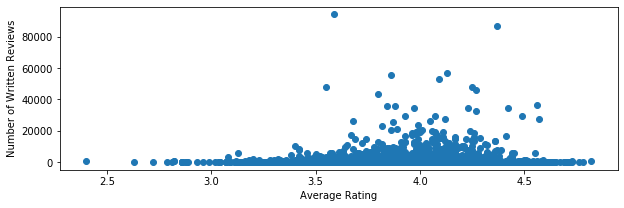

In [158]:
numReviews = books.groupby('publisher')['title'].count().sort_values(ascending = False)
fig, ax = plt.subplots(figsize = (10,3))
ax.scatter(x = books['average_rating'], y = books['text_reviews_count'])
ax.set_xlabel("Average Rating")
ax.set_ylabel("Number of Written Reviews")

#### From this graph we can gather that the more written reviews a book has the more likely the reviews are to approach the mean rating which seems to be around 4.0. This finding follows the central limit theorem.

In [159]:
books.loc[books.groupby('title')['average_rating'].idxmax()][(books['title'].str.contains('Dune')) & (books['authors'].str.contains('Frank Herbert')) & (books['publisher'] == 'Ace Books')]

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publication_date,publisher
66,105,Chapterhouse: Dune (Dune Chronicles #6),Frank Herbert,3.91,eng,436,38778,568,7/1/1987,Ace Books
67,106,Dune Messiah (Dune Chronicles #2),Frank Herbert,3.88,eng,331,97494,2359,7/15/1987,Ace Books
65,103,God Emperor of Dune (Dune Chronicles #4),Frank Herbert,3.84,eng,423,2785,166,6/15/1987,Ace Books
71,117,Heretics of Dune (Dune Chronicles #5),Frank Herbert,3.86,eng,471,45388,644,8/15/1987,Ace Books


#### There goes any confidence I had... How could one of the best series be rated around the average of all books? Real shame.

#### Now that we have a more accurate representation of the true population of the top rated books, let's see who some of the best rated authors are.

##### We're going to need to extract the year of publication here so that we can easily track an author's progress. Let's replace the 'publication_date' column with 'year_published'.

In [160]:
books['year_published'] = books['publication_date'].str[-4:]
books = books.drop(columns = ['publication_date'])
display(books.head())

,bookID,title,authors,average_rating,language_code,num_pages,ratings_count,text_reviews_count,publisher,year_published
0,1,Harry Potter and the Half-Blood Prince (Harry ...,J.K. Rowling/Mary GrandPré,4.57,eng,652,2095690,27591,Scholastic,2006
1,2,Harry Potter and the Order of the Phoenix (Har...,J.K. Rowling/Mary GrandPré,4.49,eng,870,2153167,29221,Scholastic,2004
2,4,Harry Potter and the Chamber of Secrets (Harry...,J.K. Rowling,4.42,eng,352,6333,244,Scholastic,2003
3,5,Harry Potter and the Prisoner of Azkaban (Harr...,J.K. Rowling/Mary GrandPré,4.56,eng,435,2339585,36325,Scholastic,2004
4,8,Harry Potter Boxed Set Books 1-5 (Harry Potte...,J.K. Rowling/Mary GrandPré,4.78,eng,2690,41428,164,Scholastic,2004


#### Good, now we have clean data that can be used to figure out how the authors progressed throughout their acting careers!

In [161]:
authorProg = books.groupby(['authors', 'year_published'])['average_rating'].mean().reset_index().sort_values('average_rating', ascending = False).set_index('authors')

#### Let's make a function to make getting the history of the authors easier.

In [162]:
def getAuthorHist(author):
    return authorProg[authorProg.index.str.contains(author)].sort_values('year_published')

#### I'll grab some authors that will be interesting in this context.

In [163]:
king = getAuthorHist('Stephen King')
watterson = getAuthorHist('Bill Watterson')
lovecraft = getAuthorHist('H.P. Lovecraft')
dostoyevsky = getAuthorHist('Fyodor Dostoyevsky')
tolkien = getAuthorHist('J.R.R. Tolkien')

#### While we're at it let's make a plot function as well.

In [164]:
def plotAuthorsHist(df):
    fig, ax = plt.subplots(figsize = (15,2))
    ax.bar(x = df['year_published'], height = df['average_rating'], width = 0.5)
    ax.set_xlabel("Year")
    ax.set_ylabel("Average Rating")
    ax.set_title("Average rating of books by " + str(df.index[1]))

#### Perfect! Now we can plot them.

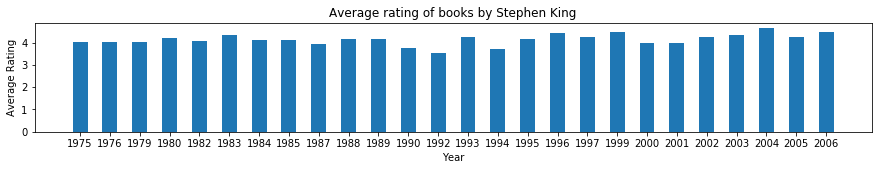

In [165]:
plotAuthorsHist(king)

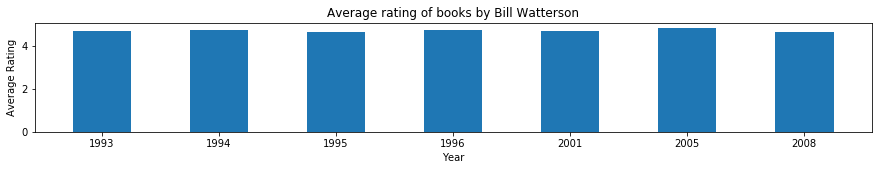

In [166]:
plotAuthorsHist(watterson)

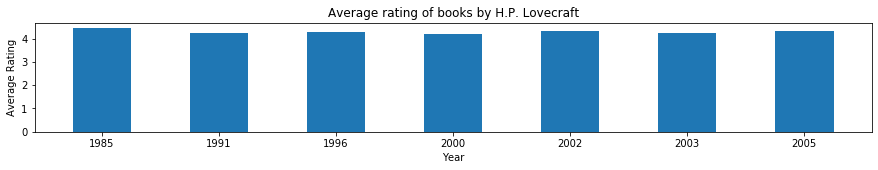

In [167]:
plotAuthorsHist(lovecraft)

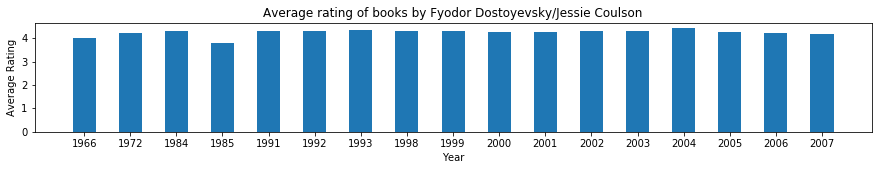

In [168]:
plotAuthorsHist(dostoyevsky)

#### Of course, these are the dates that his works were translated and published in America.

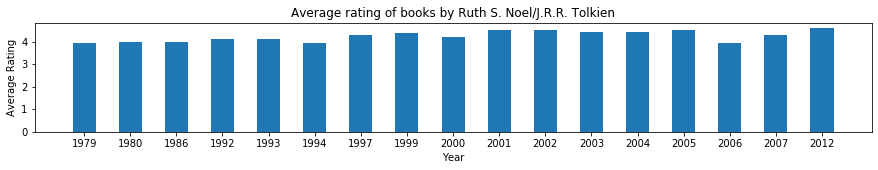

In [169]:
plotAuthorsHist(tolkien)

# Conclusion

Through the data analysis we have come to several conclusions and drafted ways to further analyze individal authors and factors that may contribute to the average rating of a book.

We have been able to conclude that the more written reviews it has the more likely it is to approach the mean rating of books on Goodreads following the Central Limit Theorem. This tells us that popularity does not necessarily mean quality.

We have also learned that the popularity of a language does not necessarily mean that the books in that language will have a higher average rating. This is likely because of the small sample size of the non-popular languages and shows possible bias from publishers on what standards need to be met by foreign authors in order to be published in America and put on Goodreads.